In [1]:
from py2neo import Graph
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

Connecting Neo4j with Jupyter 

In [3]:
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://localhost:11014", auth=("hera", "hera"))

Cypher

In [11]:
# Create relationship between article and authors for each unique article
# Each article can contain multiple authors
# Relationship Representation:
#                             (Article Name)---> (Author1)
#                                   |
#                                   v
#                                (Author2)


query="""
CALL apoc.periodic.iterate(
 'UNWIND ["dblp-ref-0.json","dblp-ref-1.json",
 "dblp-ref-2.json","dblp-ref-3.json"] AS file
 CALL apoc.load.json("https://github.com/mneedham/link-prediction/raw/master/data/" + file)
 YIELD value
 WHERE value.venue IN ["Lecture Notes in Computer Science",
 "Communications of The ACM",
 "international conference on software engineering",
 "advances in computing and communications"]
 return value',
 'MERGE (a:Article {index:value.id})
 ON CREATE SET a += apoc.map.clean(value,["id","authors","references"],[0])
 WITH a,value.authors as authors
 UNWIND authors as author
 MERGE (b:Author{name:author})
 MERGE (b)<-[:AUTHOR]-(a)'
, {batchSize: 10000, iterateList: true});

"""
graph.run(query).to_data_frame

<bound method Cursor.to_data_frame of <py2neo.database.Cursor object at 0x0000022CB93C09A0>>

In [4]:
# Total Number of Articles and Authors in the dataset extracted from the graph 

result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label) 
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
0,Article,51956
1,Author,80299


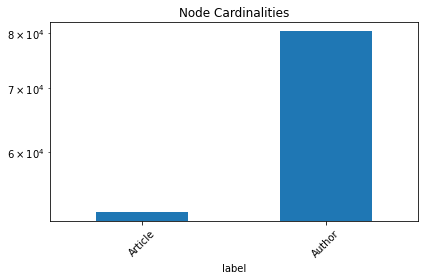

In [7]:
#graph plotting of total number of articles and authors
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
#Implementing co-author graph
#If both authors work in a same article then they will be connected with a vertex and their relationship type will be co_author 
#as they have worked in the same paper

query="""
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations = collaborations;

"""
graph.run(query).to_data_frame

<bound method Cursor.to_data_frame of <py2neo.database.Cursor object at 0x0000022CB94B6A30>>

In [14]:
# Displaying the number of articles per year
#From 1958 to 2017

query = """
MATCH (article:Article)
RETURN article.year AS year, count(*) AS count
ORDER BY year
"""
ordered_year = graph.run(query).to_data_frame()
print(ordered_year)


    year  count
0   1958     19
1   1959     42
2   1960     53
3   1961    166
4   1962    201
5   1963    180
6   1964    169
7   1965    154
8   1966    145
9   1967    150
10  1968    133
11  1969    142
12  1970    147
13  1971     69
14  1972    116
15  1973     93
16  1974     91
17  1975     80
18  1976    118
19  1977     83
20  1978    115
21  1979     77
22  1980     49
23  1981     85
24  1982     81
25  1983     83
26  1984     90
27  1985     94
28  1986     76
29  1987     81
30  1988    113
31  1989    198
32  1990    162
33  1991    138
34  1992    129
35  1993    213
36  1994    209
37  1995    228
38  1996    243
39  1997    902
40  1998   1620
41  1999   1446
42  2000   1985
43  2001   2719
44  2002   3612
45  2003   3678
46  2004   5064
47  2005   5056
48  2006   7536
49  2007    640
50  2008    607
51  2009    817
52  2010    812
53  2011   1162
54  2012   1935
55  2013    959
56  2014   2040
57  2015   2075
58  2016   2308
59  2017    168


In [8]:
#import seaborn as sns

In [ ]:
# plt.figure(figsize = (28, 8))
# splot = sns.barplot(x = 'year', y = 'count')
# plt.ylabel("No of Article")
# plt.xlabel("Year")
# plt.legend()
# plt.tight_layout()
# # Display a figure.
# plt.show()

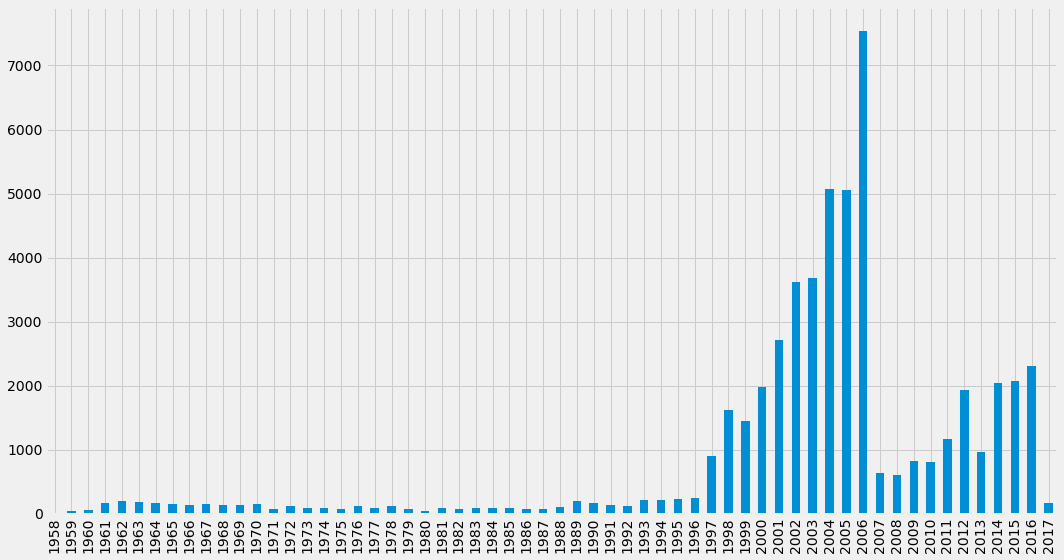

In [15]:
#graph generation for total number of article published from year 1958 to 2017
plt.style.use('fivethirtyeight')
ax = ordered_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [43]:
#Here the label true means 30897 papers were published before 2006 and 21059 articles were published in between 2006 to 2017
query="""
MATCH (article:Article)
RETURN article.year < 2006 AS paper_published_before_2006, count(*) AS count
"""
graph.run(query).to_data_frame()


,paper_published_before_2006,count
0,False,21059
1,True,30897


In [11]:
#Creating new relationship(coauthor_early) between the authors who collaborated before year 2006
query="""
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year < 2006
MERGE (a1)-[coauthor:COAUTHOR_EARLY {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""
graph.run(query).to_data_frame

<bound method Cursor.to_data_frame of <py2neo.database.Cursor object at 0x00000206CA31FC70>>

In [12]:
#Creating new relationship(coauthor_late) between the authors who collaborated from 2006 to 2017
query="""
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year >= 2006
MERGE (a1)-[coauthor:COAUTHOR_LATE {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""
graph.run(query).to_data_frame

<bound method Cursor.to_data_frame of <py2neo.database.Cursor object at 0x00000206CA505B50>>

In [18]:
#Displaying the total number of edges for each relationship we formed in the graph

result = {"relationshipType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relationshipType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relationshipType,count
3,COAUTHOR_LATE,74128
2,COAUTHOR_EARLY,81096
0,AUTHOR,140575
1,CO_AUTHOR,155224


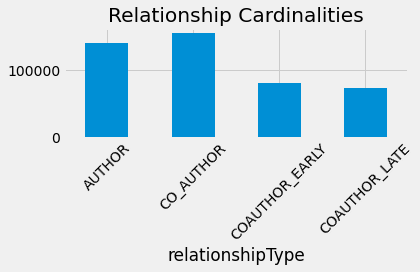

In [21]:
#Graph Plotting
rels_df.plot(kind='bar', x='relationshipType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
#Total number of coauthor_early pairs that means the authors collaborated before 2006
query="""
MATCH ()-[:COAUTHOR_EARLY]->()
RETURN count(*) AS COAUTHOR_EARLY_PAIRS
"""
graph.run(query).to_data_frame()

,COAUTHOR_EARLY_PAIRS
0,81096


In [45]:
#Total number of coauthor_late pairs that means the authors collaborated from 2006 to 2017
query="""
MATCH ()-[:COAUTHOR_LATE]->()
RETURN count(*) AS COAUTHOR_LATE_PAIRS
"""
graph.run(query).to_data_frame()

,COAUTHOR_LATE_PAIRS
0,74128


In [ ]:
# pip install py2neo==4.1.3 pandas sklearn

In [ ]:
# ! pip install sklearn matplotlib neo4j pandas

In [4]:
# from py2neo import Graph
from collections import Counter

In [5]:
#Userdefined function for down sampling
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [25]:
#Training data will be taken from the coauthor_early part as it contains approximately 60% data
# Checking if the authors have worked together
#If yes then the label will be set to 1
train_existing_links = graph.run("""
MATCH (author:Author)-[:COAUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()


#In the missing link part we will find out the authors who haven't collaborated together before 2006 and set the label 0
#As the graph has so many nodes it will generate more 0 labels then 1 if we run the query for the entire graph
#That's why we will first check if they satisfy the condition coauthor_early and then will check for next 2/3 hops(edges) 
#to find out the nodes (mainly the edge between them) who haven't collaborated before 2006
#Then set the value to 0
#if we find any duplicate values we will drop that
train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_EARLY]-()
MATCH (author)-[:COAUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:COAUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [26]:
#training dataframe will contain both coauthor_early pairs who have collaborated before 2006 and the pairs who have not.
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [27]:
training_df.head()

,node1,node2,label
981419,13058,120540,1
989332,16173,43949,1
990477,16650,16651,1
292121,23590,71500,0
417937,31072,31072,0


In [28]:
#Test data will be taken from the coauthor_late part as it contains approximately 40% data
# Checking if the authors have worked together from the coauthor_late relationship(from 2006 to 2017)
#If yes then the label will be set to 1

test_existing_links = graph.run("""
MATCH (author:Author)-[:COAUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

#In the missing link part we will find out the authors who haven't collaborated together from 2006 to 2017 and set the label 0
#As the graph has so many nodes it will generate more 0 labels then 1 if we run the query for the entire graph
#That's why we will first check if they satisfy the condition coauthor_late and then will check for next 2/3 hops(edges) 
#to find out the nodes (mainly the edge between them) who haven't collaborated from 2006 to 2017
#Then set the value to 0
#if we find any duplicate values we will drop that

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_LATE]-()
MATCH (author)-[:COAUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:COAUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [29]:
#test dataframe will contain both coauthor_late pairs who have collaborated from 2006 to 2017 and the pairs who have not.
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [30]:
test_df.head()

,node1,node2,label
244522,27545,75873,0
249835,28106,77951,0
1299373,50936,115653,1
1268794,11785,11788,1
575913,73129,11932,0


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

In [20]:
#from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

In [13]:
#This function takes two parameter
#Training and testing dataframe will use this function to find out the commonNeighbors,preferentialAttachment and totalNeighbors
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [34]:
#Passing the training dataframe and their relationship type to the defined function
#It will generate the cn,pn and tn for each pair of nodes in the training dataframe
training_df = apply_graphy_features(training_df, "COAUTHOR_EARLY")

In [35]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,13058,120540,1,2.0,24.0,9.0
1,16173,43949,1,1.0,42.0,12.0
2,16650,16651,1,2.0,81.0,28.0
3,23590,71500,0,1.0,63.0,15.0
4,31072,31072,0,0.0,9.0,3.0


In [36]:
#Passing the test dataframe and their relationship type to the defined function
#It will generate the cn,pn and tn for each pair of nodes in the test dataframe
test_df = apply_graphy_features(test_df, "COAUTHOR_LATE")

In [37]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,27545,75873,0,0.0,96.0,20.0
1,28106,77951,0,0.0,15.0,8.0
2,50936,115653,1,5.0,84.0,15.0
3,11785,11788,1,1.0,12.0,6.0
4,73129,11932,0,0.0,3.0,4.0


In [38]:
#Generating the accuracy precision, recall, confusion matrix for 2/3 hops test dataframe
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
cnf_matrix = confusion_matrix(y_test, predictions)
display("Confusion Matrix", confusion_matrix(y_test, predictions))
print("Classification Report\n", classification_report(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9134470105763004

'Precision'

0.9251234533651446

'Recall'

0.899714008202029

'Confusion Matrix'

array([[68730,  5398],
       [ 7434, 66694]], dtype=int64)

Classification Report
               precision    recall  f1-score   support

           0       0.90      0.93      0.91     74128
           1       0.93      0.90      0.91     74128

    accuracy                           0.91    148256
   macro avg       0.91      0.91      0.91    148256
weighted avg       0.91      0.91      0.91    148256



[('cn', 0.6909907420545209),
 ('pa', 0.18462470668769956),
 ('tn', 0.12438455125777954)]

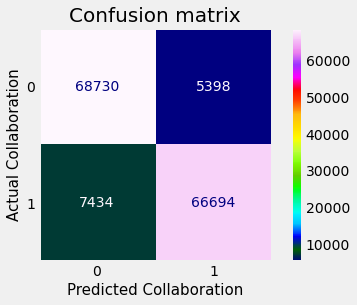

In [39]:
#Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap='gist_ncar', values_format = '.0f')
disp.ax_.grid(False)
plt.title('Confusion matrix', fontsize = 20)
plt.ylabel('Actual Collaboration', fontsize = 15)
plt.xlabel('Predicted Collaboration', fontsize = 15)
plt.show()

In [40]:
def evaluate_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    precision = precision_score(actual, predictions)
    recall = recall_score(actual, predictions)
    
    metrics = ["accuracy", "precision", "recall"]
    values = [accuracy, precision, recall]    
    return pd.DataFrame(data={'metric': metrics, 'value': values})
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

In [41]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]
evaluate_model(predictions, y_test)

,metric,value
0,accuracy,0.913447
1,precision,0.925123
2,recall,0.899714


In [42]:
from sklearn import metrics
probs = classifier.predict_proba(test_df[columns])
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
roc_auc = metrics.roc_auc_score(y_test, probs)

ROC Curve for the output from using random forest classifier using the dataframe where the test dataframe contained the 0 label for 2/3 hops

Text(0, 0.5, 'True Positive Rate')

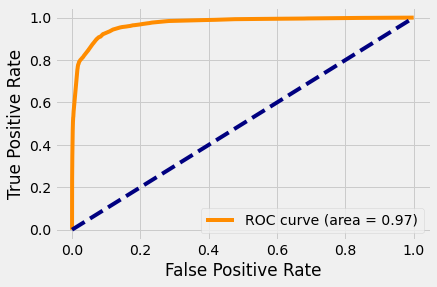

In [43]:
plt.plot(fpr, tpr, color = 'darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

For 3/4 hops

In [6]:
#Training data will be taken from the coauthor_early part as it contains approximately 60% data
# Checking if the authors have worked together
#If yes then the label will be set to 1
train_existing_links1 = graph.run("""
MATCH (author:Author)-[:COAUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

#In the missing link part we will find out the authors who haven't collaborated together before 2006 and set the label 0
#As the graph has so many nodes it will generate more 0 labels then 1 if we run the query for the entire graph
#That's why we will first check if they satisfy the condition coauthor_early and then will check for next 3/4 hops(edges) 
#to find out the nodes (mainly the edge between them) who haven't collaborated before 2006
#Then set the value to 0
#if we find any duplicate values we will drop that

train_missing_links1 = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_EARLY]-()
MATCH (author)-[:COAUTHOR_EARLY*3..4]-(other)
WHERE not((author)-[:COAUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links1 = train_missing_links1.drop_duplicates()

In [25]:
training_df1 = train_missing_links1.append(train_existing_links1, ignore_index=True)
training_df1['label'] = training_df1['label'].astype('category')
training_df1 = down_sample(training_df1)

In [26]:
training_df1.head()

,node1,node2,label
1320401,52396,73395,0
2354084,28574,28575,1
1128893,46169,57198,0
709697,24278,22576,0
1961112,96873,29017,0


In [9]:
#Test data will be taken from the coauthor_late part as it contains approximately 40% data
# Checking if the authors have worked together from the coauthor_late relationship(from 2006 to 2017)
#If yes then the label will be set to 1

test_existing_links1 = graph.run("""
MATCH (author:Author)-[:COAUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

#In the missing link part we will find out the authors who haven't collaborated together from 2006 to 2017 and set the label 0
#As the graph has so many nodes it will generate more 0 labels then 1 if we run the query for the entire graph
#That's why we will first check if they satisfy the condition coauthor_late and then will check for next 3/4 hops(edges) 
#to find out the nodes (mainly the edge between them) who haven't collaborated from 2006 to 2017
#Then set the value to 0
#if we find any duplicate values we will drop that

test_missing_links1 = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_LATE]-()
MATCH (author)-[:COAUTHOR_LATE*3..4]-(other)
WHERE not((author)-[:COAUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links1 = test_missing_links1.drop_duplicates()

In [10]:
test_df1 = test_missing_links1.append(test_existing_links1, ignore_index=True)
test_df1['label'] = test_df1['label'].astype('category')
test_df1 = down_sample(test_df1)

In [11]:
test_df1.head()

,node1,node2,label
2714834,95052,12053,0
1257125,57639,71799,0
3946680,118239,118242,1
600764,24896,11518,0
3922014,70317,70320,1


In [14]:
training_df1 = apply_graphy_features(training_df1, "COAUTHOR_EARLY")

In [15]:
training_df1.head()

,node1,node2,label,cn,pa,tn
0,14607,23492,0,1.0,12.0,6.0
1,11423,45947,0,3.0,246.0,44.0
2,98817,98266,0,0.0,1.0,2.0
3,19407,25248,0,0.0,6.0,5.0
4,15292,18022,0,1.0,44.0,14.0


In [16]:
test_df1 = apply_graphy_features(test_df1, "COAUTHOR_LATE")

In [17]:
test_df1.head()

,node1,node2,label,cn,pa,tn
0,95052,12053,0,0.0,90.0,21.0
1,57639,71799,0,0.0,22.0,13.0
2,118239,118242,1,6.0,49.0,8.0
3,24896,11518,0,0.0,36.0,15.0
4,70317,70320,1,5.0,36.0,7.0


In [21]:
columns = ["cn", "pa", "tn"]

X1 = training_df1[columns]
y1 = training_df1["label"]
classifier.fit(X1, y1)

predictions = classifier.predict(test_df1[columns])
y_test1 = test_df1["label"]

display("Accuracy", accuracy_score(y_test1, predictions))
display("Precision", precision_score(y_test1, predictions))
display("Recall", recall_score(y_test1, predictions))
cnf_matrix = confusion_matrix(y_test1, predictions)
display("Confusion Matrix", confusion_matrix(y_test1, predictions))
print("Classification Report\n", classification_report(y_test1, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9415335635657242

'Precision'

0.9683073401058807

'Recall'

0.912947873947766

'Confusion Matrix'

array([[71913,  2215],
       [ 6453, 67675]], dtype=int64)

Classification Report
               precision    recall  f1-score   support

           0       0.92      0.97      0.94     74128
           1       0.97      0.91      0.94     74128

    accuracy                           0.94    148256
   macro avg       0.94      0.94      0.94    148256
weighted avg       0.94      0.94      0.94    148256



[('cn', 0.8010985261086462),
 ('pa', 0.11848192469783796),
 ('tn', 0.08041954919351596)]

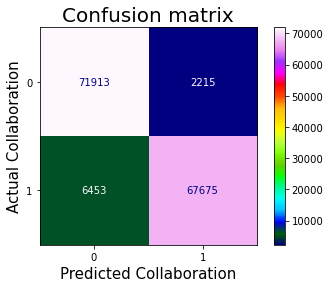

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap='gist_ncar', values_format = '.0f')
disp.ax_.grid(False)
plt.title('Confusion matrix', fontsize = 20)
plt.ylabel('Actual Collaboration', fontsize = 15)
plt.xlabel('Predicted Collaboration', fontsize = 15)
plt.show()

In [23]:
from sklearn import metrics
probs = classifier.predict_proba(test_df1[columns])
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_test1, probs)
roc_auc = metrics.roc_auc_score(y_test1, probs)

Text(0, 0.5, 'True Positive Rate')

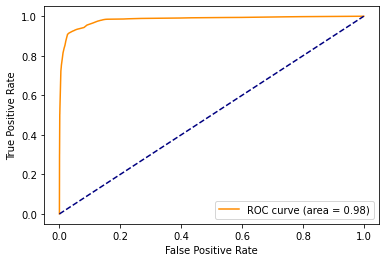

In [24]:
plt.plot(fpr, tpr, color = 'darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')